# Изучение закономерностей, определяющих успешность игр

**Описание провекта:** 

В нашем распоряжении данные интернет-магазине "Стримчик", который продаёт по всему миру компьютерные игры. Данные включают в себя информацию об играх, их продажах, оценки пользователей и экспертов, жанры, платформы и рейтинг от организации ESRB. Наша задача -- выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Шаг 1. Обзор данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats as st
import numpy as np

Для обзора данных воспользуемся методами head(), info() и describe().

In [2]:
data = pd.read_csv('games.csv')
display(data.head())
display(data.info())
data.describe()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


### Вывод

В данных встречаются небольшие недостатки, которые нужно будет поправить:

* в колонках year_of_release, user_score некорректно указан тип данных;
* присутствуют пропущенные значения;
* привести названия колонок к нижнему регистру;
* проверить есть ли в данных дубликаты

Это только первоначальные наблюдения. Проведем подробную предобработку данных, чтобы выявить все аномалии.

## Шаг 2. Предобработка данных

1. Приведем названия колонок к нижнему регистру.

In [3]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

2. Обработка пропущенных значений

Посмотрим в каких столбцах присутствуют пропущенные значения. 

In [4]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски встречаются в столбцах: name, year_of_release, genre, critic_score, user_score, rating.  

**name** -- название игры

Посчитаем какую долю составляют пропущенные значения в колонке.

In [5]:
(data['name'].isna().mean())*100

0.011965300628178284

Пропущенные значения составляют менее 1%. Такими данными можно пренебречь, они не повлияют на дальнейшее исследование. Удалим их. 

In [6]:
data = data.dropna(subset=['name']) 

**year_of_release** -- год выпуска

Посчитаем какую долю составляют пропущенные значения в колонке.

In [7]:
(data['year_of_release'].isna().mean())*100

1.6095255190570215

Пропущенные значения составляют чуть больше 1%. Такими данными можно пренебречь, они не повлияют на дальнейший анализ. Удалим их. 

In [8]:
data = data.dropna(subset=['year_of_release']) 

**genre** -- жанр игры

In [9]:
(data['genre'].isna().mean())*100

0.0

In [10]:
data['genre'].isna().sum()

0

После обработки пропущенных значений в колонках year_of_release и name пропусков в столбце genre не осталось. 

**critic_score**, **user_score** -- оценка критиков, оценка пользователей

Столбцы critic_score и user_score отображают оценки критиков и пользователей. Принимаем решение оставить пропусти без изменений, так как заполнить их корректно возможности нет. Игр очень много, мы не можем учесть их все и заполнить пропуски средним или медианным значениями. Также, мы не можем указать значение 0, так как отсутствие оценки — не значит оценка 0.

**rating** -- рейтинг от организации ESRB

Посмотрим какие категории содержатся в колонке rating.

In [11]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Ассоциация ESRB определяющая возрастной рейтинг компьютерных игр. Они бывают следующими:
* EC — Для детей младшего возраста
* E — Для всех
* E10+ — Для всех от 10 лет и старше
* T — Подросткам
* M — Для взрослых (от 17 лет)
* AO — Только для взрослых
* RP — Рейтинг ожидается
* nan — пустое значение    

В столбце встречаются пропущенные значения. Предположим, что рейтинг им еще не успели определить. Заменим пропуски на "RP".

In [12]:
data['rating'] = data['rating'].fillna('RP') 

Стоит обратить внимание, что в данных встречается категория "K-A". Такая категория действительно существовала, но со временем устарела. Она означала "Для взрослых и детей". Заменим "K-A" на "E".

In [13]:
def rating(i):
    if i == 'K-A':
        return 'E'
    else:
        return i

In [14]:
data['rating'] = data['rating'].apply(rating)

3. Изменим типы данных

In [15]:
data['year_of_release'] = data['year_of_release'].astype('int')

В столбце user_score невозможно применить метод astype() так как присутствует значения 'tbd' ('to be done', то есть оценки пока нет). Для того чтобы изменить тип данных, заменим значение 'tbd' на 'nan'. Для этого воспользуемся методом replace(), а затем изменим тип данных.

In [16]:
data['user_score'] = data['user_score'].replace("tbd", 'nan')
data['user_score'] = data['user_score'].astype('float')

4. Проверим наличие дубликатов

In [17]:
data.duplicated().sum()

0

5. Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец. 

In [18]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

Предобрабтка данных завершена. Выведем общую информацию о датафрейме для итоговой проверки.

In [19]:
data.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,40.24


**Вывод:** Предобработка данных завершена. Мы привели названия столбцов к нижнему регистру, обработали пропуски там, где это необходимо для дальнейшего исследования, изменили типы данных и проверили данные на наличие дубликатов. Теперь мы готовы переходить к проведению анализа. 

## Шаг 3. Исследовательский анализ данных

Выясним, сколько игр выпускалось в разные годы. 

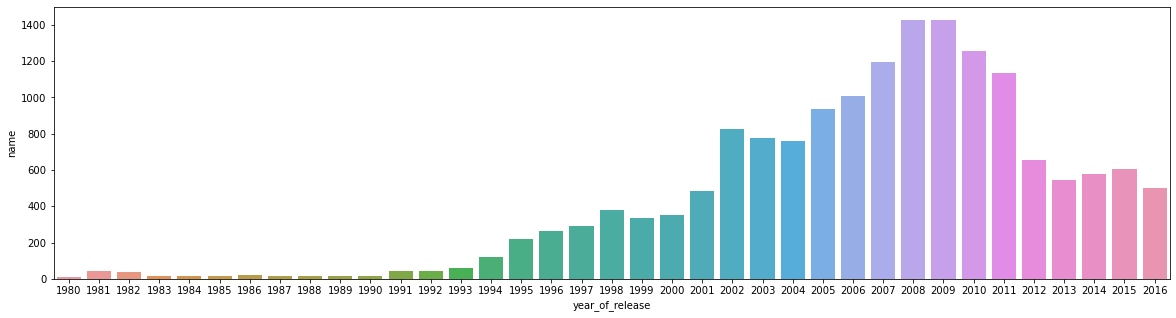

In [20]:
genre_in_year_pivot = (data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')).sort_values('name', ascending = False)
plt.figure(figsize=(20,5))
sns.barplot(data = genre_in_year_pivot, x = genre_in_year_pivot.index, y = 'name')
plt.show()

In [21]:
games_in_year = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
games_in_year.columns = ['count_name']
games_in_year.sort_index()

,count_name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


**Вывод:** Из данных выше можно заметить, что в 1994 произошел резкий скачек и игр выпустили в два раза больше. С каждым годом выпускали все больше игр, и этот темп сохранился вплоть до 2011 года. Максимальное количество выпущенных игр за год составило 1427. С 2012 по 2016 года темпы упали и стали выпускать не больше 653 игр в год. Данные за все периоды представляют интерес, но в данном исследовании нам они не нужны. 

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

In [22]:
platform = data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
platform.columns = ['platform_total_sales']
platform.sort_values(by = 'platform_total_sales', ascending=False).head(10)

,platform_total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Из данных выше видно, что платформы с наибольшими суммарными продажами являются: PS2, X360, PS3, Wii, DS. Построим распределение по годам для этих платформ. 

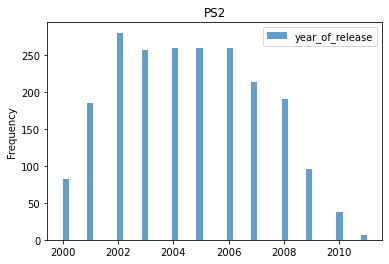

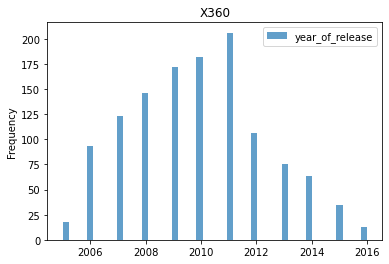

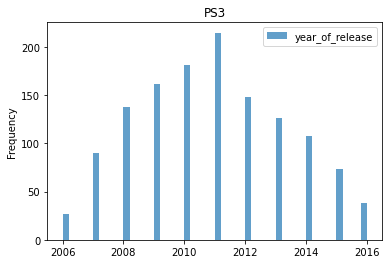

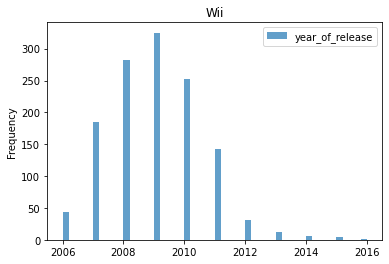

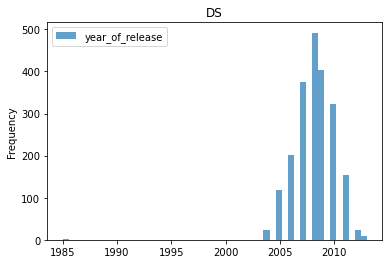

In [23]:
for platform_item in ['PS2', 'X360', 'PS3', 'Wii', 'DS']:
    data[data['platform'] == platform_item].plot(x = 'total_sales', y = 'year_of_release',\
                                                 bins=50, alpha=0.7,  kind = 'hist', title = str(platform_item))

Построим единый график по годам для топ-5 платформ. 

<AxesSubplot:xlabel='year_of_release'>

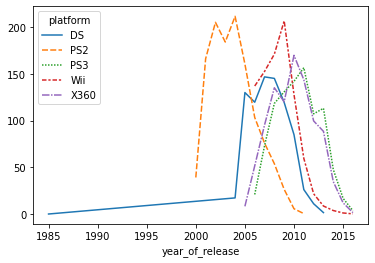

In [24]:
platforms_table = data.loc[data['platform'].isin(['PS2', 'X360', 'PS3', 'Wii', 'DS'])]
platforms = platforms_table.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
sns.lineplot(data=platforms)

**Вывод:** Потенциально прибыльные и лидирующие по продажам платформы являются PS2, X360, PS3, Wii, DS. Выбранные платформы появились в начале 2000-х. Характерный срок жизни игр примерно 10 лет. Большинство из платформ достигли пика по продажам в 2008 - 2011 года. Далее у каждого, в своем темпе, начали снижаться продажи. Так как индустрия компьютерных игр является быстро развивающейся, на рынок выходит все больше платформ и появляется все больше игр, принимаем решение для анализа взять данные последних 3-х лет. Данные будут актуальными и их будет достаточно для проведения анализа.

Создадим новый датафрейм и оставим в нем только необходимые нам годы.

In [25]:
platforms_table = platforms_table[platforms_table['year_of_release'] >= 2014]
platforms_table['year_of_release'].unique()

array([2014, 2015, 2016])

Так как мы ограничили временной промежуток, стоит еще раз посмотреть, как менялись продажи по платформам и какие из платформ мы будем использовать для анализа. 

In [26]:
platforms_check = platforms_table.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
platforms_check.sort_values(by = 'total_sales', ascending=False).head(10)

,total_sales
platform,
PS3,68.18
X360,48.22
Wii,5.07


У нас остались всего 3 платформы - PS3, X360, Wii. По ним мы и будем проводить анализ. 

Создадим новые датафреймы для каждой из платформ с учетом полученной информации.

In [27]:
X360 = data[(data['platform'] == 'X360') & (data['year_of_release'] >= 2014)]
PS3 = data[(data['platform'] == 'PS3') & (data['year_of_release'] >= 2014)]
Wii = data[(data['platform'] == 'Wii') & (data['year_of_release'] >= 2014)]

Построим график "ящик с усами" по глобальным продажам игр в разбивке по платформам.

<AxesSubplot:title={'center':'total_sales'}, xlabel='[platform]'>

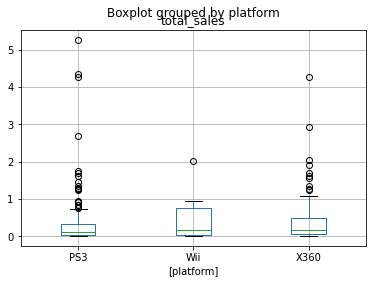

In [28]:
platforms_table.boxplot(column=['total_sales'], by = ['platform'])

График показал наличие выбросов у каждой из платформ. Это связано с тем, что у каждой из платформ были выпущены игры, которые обрели особую популярность. 

График хорош, однако не дает представления об медиане и квартилях. Построим еще один для более наглядного сравнения платформ. 

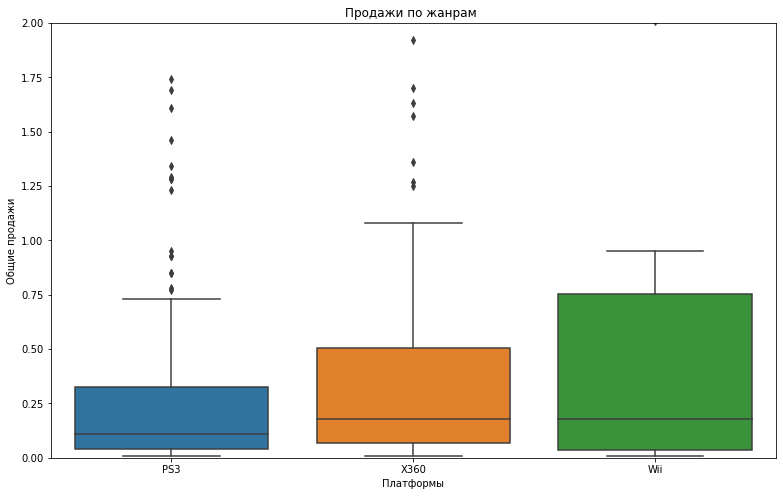

In [29]:
plt.figure(figsize=(13, 8))
(sns.boxplot(data = platforms_table, y = 'total_sales', x='platform')
    .set(title = 'Продажи по жанрам ', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 2)))

plt.show()

**Вывод:** Графики показали, что у платформы PS3 больше всего игр ставшими особо популярными. Не сильно отстает платформа X360. Можно заметить, что у всех трех графиков медиана находится ближе к первому квартилю. Также можно заметить, что у нас преобладают платформы с мегапопулярными играми и довольно большими продажами.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

**X360**

Диаграмма рассеяния для X360


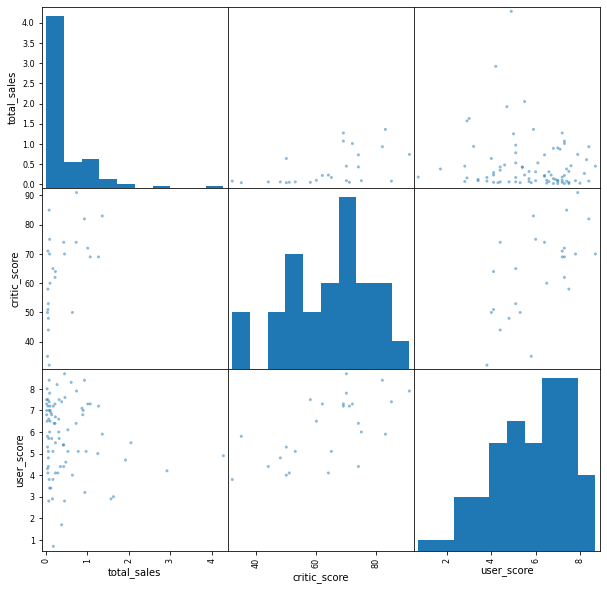

None

,total_sales,critic_score,user_score
total_sales,1.000000,0.525723,-0.138445
critic_score,0.525723,1.000000,0.625309
user_score,-0.138445,0.625309,1.000000


In [30]:
print("Диаграмма рассеяния для X360")
pd.plotting.scatter_matrix(X360[['total_sales', 'critic_score', 'user_score']], figsize=(10, 10))
display(plt.show())
X360[['total_sales', 'critic_score', 'user_score']].corr()

**Вывод:** Корреляции между продажами и оценкой критиков по платформе X360 есть. Коэффициент Пирсован равен 0,52, что говорит о сильной зависимости. Корреляции между общими продажами и оценкой пользователей практически нет. Коэффициент Пирсован равен -0.13, что говорит о слабой зависимости. 

**PS3**

In [31]:
PS3[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.446575,-0.166761
critic_score,0.446575,1.000000,0.693445
user_score,-0.166761,0.693445,1.000000


Text(0.5, 1.0, 'Диаграмма рассеяния для PS3 (оценка пользователей)')

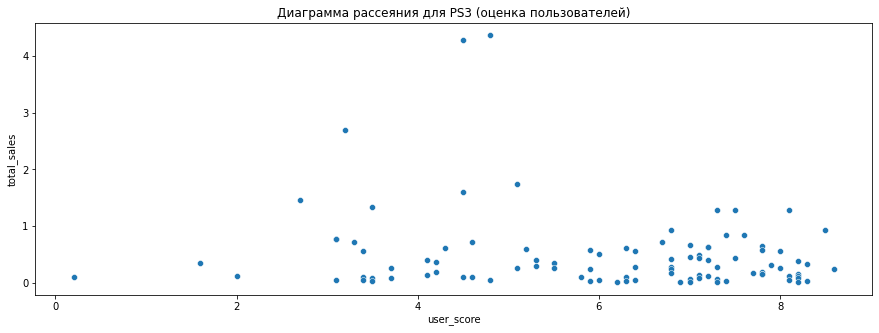

In [32]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='user_score', y='total_sales', data=PS3)
plt.title('Диаграмма рассеяния для PS3 (оценка пользователей)')

Text(0.5, 1.0, 'Диаграмма рассеяния для PS3 (оценка критиков)')

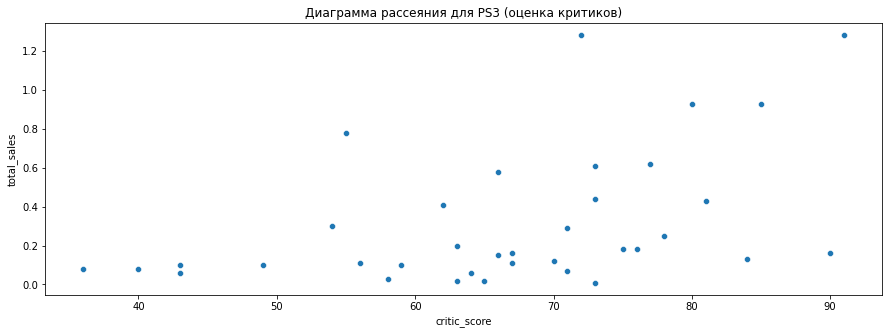

In [33]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='critic_score', y='total_sales', data=PS3)
plt.title('Диаграмма рассеяния для PS3 (оценка критиков)')

**Вывод:** Корреляции между продажами и оценкой критиков по платформе PS3 есть. Коэффициент Пирсован равен 0.44, что говорит о существенной зависимости. Корреляции между общими продажами и оценкой пользователей практически нет. Коэффициент Пирсован равен -0.16, что говорит о слабой зависимости.

**Wii**

In [34]:
Wii[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.0,NaN,1.0
critic_score,NaN,NaN,NaN
user_score,1.0,NaN,1.0


Text(0.5, 1.0, 'Диаграмма рассеяния для Wii (оценка пользователей)')

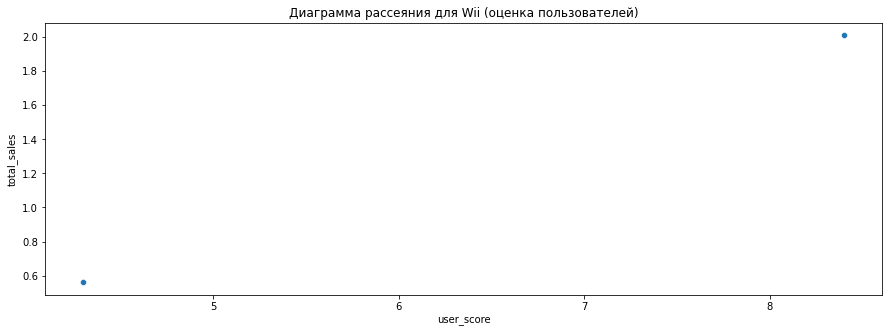

In [35]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='user_score', y='total_sales', data=Wii)
plt.title('Диаграмма рассеяния для Wii (оценка пользователей)')

Text(0.5, 1.0, 'Диаграмма рассеяния для Wii (оценка критиков)')

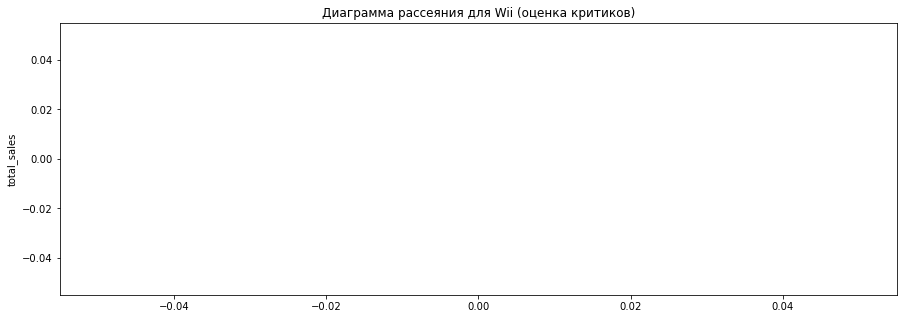

In [36]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='critic_score', y='total_sales', data=Wii)
plt.title('Диаграмма рассеяния для Wii (оценка критиков)')

**Вывод:** У платформы Wii ситуация неоднозначна. Мы не смогли оценить зависимость между оценкой критиков и общей суммой продаж, так как данных слишком мало. 

Посмотрим на общее распределение игр по жанрам.

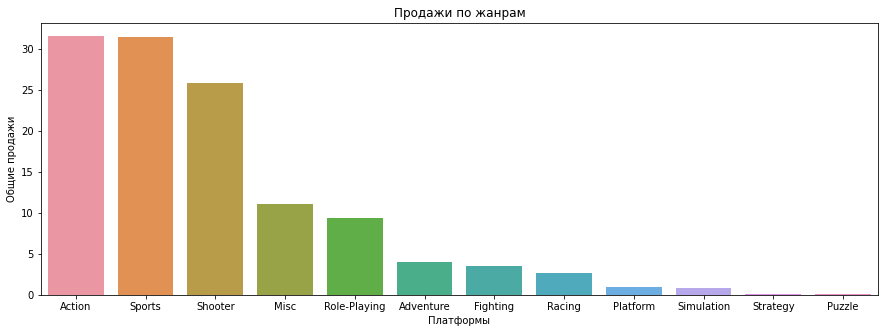

In [37]:
genre_pivot = (platforms_table.pivot_table(
    index='genre', values='total_sales', aggfunc='sum')).sort_values('total_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = genre_pivot, x = genre_pivot.index, y = 'total_sales').set(
    title='Продажи по жанрам', xlabel = 'Платформы', ylabel = 'Общие продажи')
plt.show()

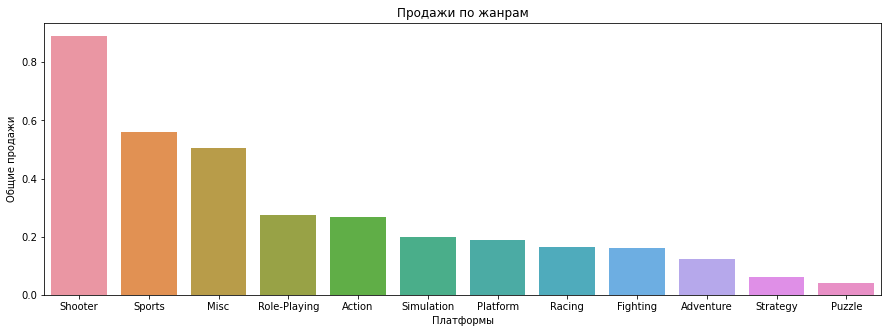

In [38]:
genre_pivot = (platforms_table.pivot_table(
    index='genre', values='total_sales', aggfunc='mean')).sort_values('total_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = genre_pivot, x = genre_pivot.index, y = 'total_sales').set(
    title='Продажи по жанрам', xlabel = 'Платформы', ylabel = 'Общие продажи')
plt.show()

**Вывод:** Общая прибыть по жанрам с высокими и низкими продажами отличается во много раз. На первом графике, где мы оценивание суммарную прибыль по жанрам, можно увидеть, что самыми популярными жанрами являются Action, Sports и Shooter. Однако выводы делать рано. Для более точного анализа нам важно посмотреть на усредненные значения для каждого жанра. На втором графике мы уже видим другую картину. Лидерами оказались Shooter, Sports, Misc.

## Шаг 4. Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5).

In [39]:
data_new = data[data['year_of_release'] >= 2014]

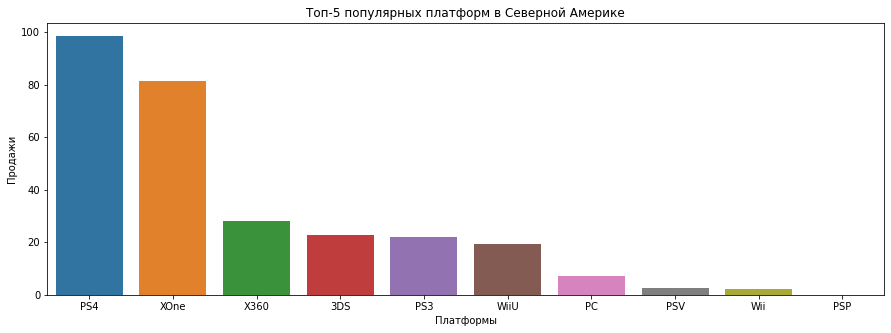

In [40]:
NA_pivot = (data_new.pivot_table(
    index='platform', values='na_sales', aggfunc='sum')).sort_values('na_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = NA_pivot, x = NA_pivot.index, y = 'na_sales').set(
    title='Топ-5 популярных платформ в Северной Америке', xlabel = 'Платформы', ylabel = 'Продажи')
plt.show()

In [41]:
data_new.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending = False).head()

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


В Северной Америке топ-5 самых популярных платформ - PS4, XOne, X360, 3DS, PS3.

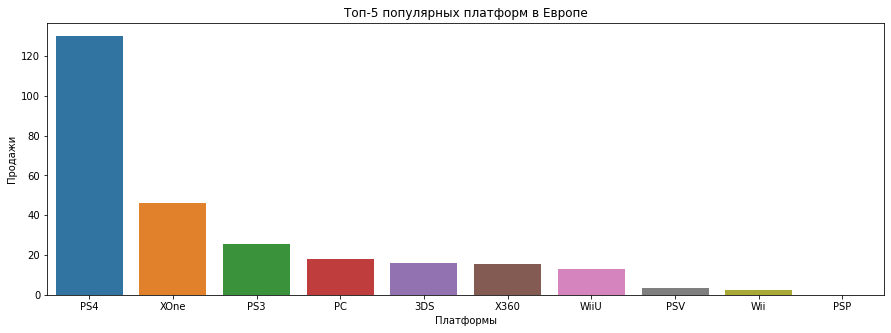

In [42]:
EU_pivot = (data_new.pivot_table
            (index='platform', values='eu_sales', aggfunc='sum')).sort_values('eu_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = EU_pivot, x = EU_pivot.index, y = 'eu_sales').set(
    title='Топ-5 популярных платформ в Европе', xlabel = 'Платформы', ylabel = 'Продажи')
plt.show()

In [43]:
data_new.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending = False).head()

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


В Европе топ-5 самых популярных платформ - PS4, XOne, PS3, PC, 3DS.

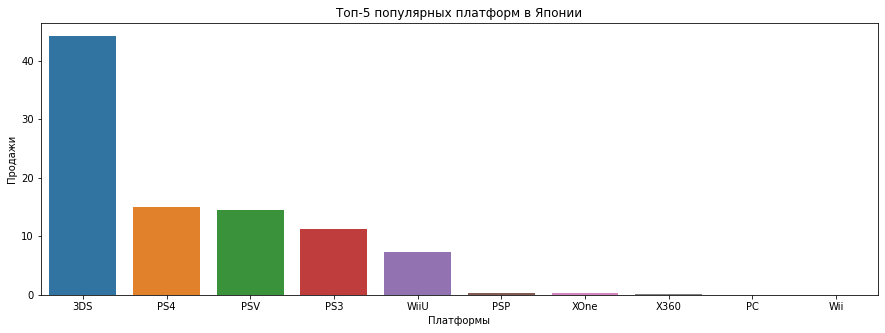

In [44]:
JP_pivot = (data_new.pivot_table(
    index='platform', values='jp_sales', aggfunc='sum')).sort_values('jp_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = JP_pivot, x = JP_pivot.index, y = 'jp_sales').set(
    title='Топ-5 популярных платформ в Японии', xlabel = 'Платформы', ylabel = 'Продажи')
plt.show()

In [45]:
data_new.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending = False).head()

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


В Японии топ-5 самых популярных платформ - 3DS, PS4, PSV, PS3, WiiU. 

**Вывод:** 
* В Северной Америке топ-5 самых популярных платформ - PS4, XOne, X360, 3DS, PS3. Объемы продаж, следующие: PS4 - 98.61, XOne - 81.27, X360 - 28.30, 3DS - 22.64, PS3 - 22.05. 

* В Европе топ-5 самых популярных платформ - PS4, XOne, PS3, PC, 3DS. Объемы продаж, следующие: PS4 - 130.04, XOne - 46.25, PS3 - 25.54, PC - 17.97, 3DS - 16.12. 

* В Японии топ-5 самых популярных платформ - 3DS, PS4, PSV, PS3, WiiU. Объемы продаж, следующие: 3DS - 44.24, PS4 - 15.02, PSV - 14.54, PS3 - 11.22, WiiU - 7.31.  

* Самые популярные жанры (топ-5).

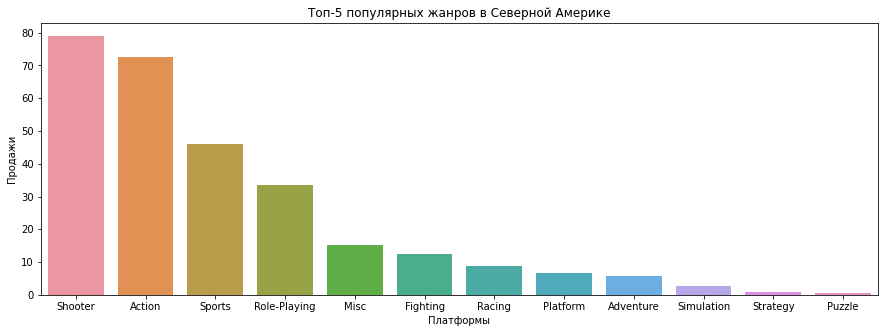

In [46]:
NA_pivot = (data_new.pivot_table(
    index='genre', values='na_sales', aggfunc='sum')).sort_values('na_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = NA_pivot, x = NA_pivot.index, y = 'na_sales').set(
    title='Топ-5 популярных жанров в Северной Америке', xlabel = 'Платформы', ylabel = 'Продажи')
plt.show()

In [47]:
data_new.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending = False).head()

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05


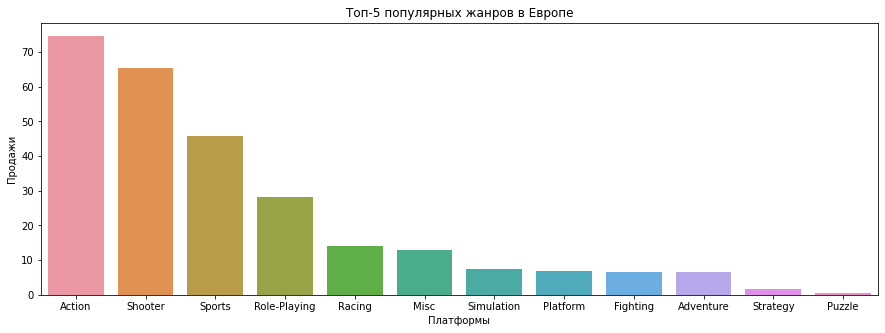

In [48]:
EU_pivot = (data_new.pivot_table(
    index='genre', values='eu_sales', aggfunc='sum')).sort_values('eu_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = EU_pivot, x = EU_pivot.index, y = 'eu_sales').set(
    title='Топ-5 популярных жанров в Европе', xlabel = 'Платформы', ylabel = 'Продажи')
plt.show()

In [49]:
data_new.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending = False).head()

,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13


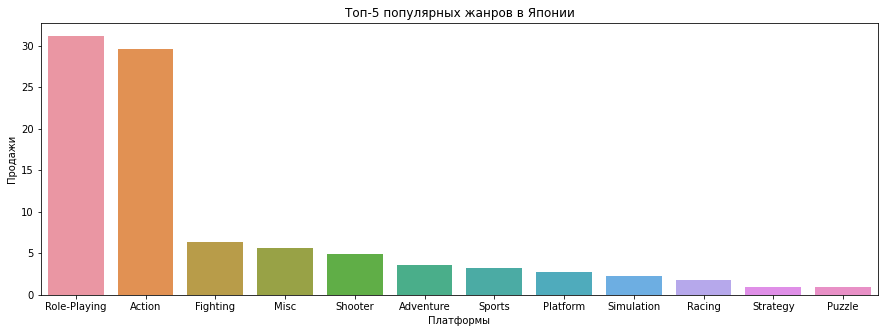

In [50]:
JP_pivot = (data_new.pivot_table(
    index='genre', values='jp_sales', aggfunc='sum')).sort_values('jp_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = JP_pivot, x = JP_pivot.index, y = 'jp_sales').set(
    title='Топ-5 популярных жанров в Японии', xlabel = 'Платформы', ylabel = 'Продажи')
plt.show()

In [51]:
data_new.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending = False).head()

,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87


**Вывод:** В Северной Америке и в Европе самые популярные жанры практически совпадают. Топ-5 популярных жанров в Северной Америке: Shooter, Action, Sports, Role-Playing, Misc. В Европе Топ-5 популярных жанров: Action, Shooter, Sports, Role-Playing, Racing. 
В Японии Топ-5 популярных жанров следующие: Role-Playing, Action, Fighting, Misc, Shooter. 

* Влияние рейтинга ESRB на продажи в отдельном регионе?

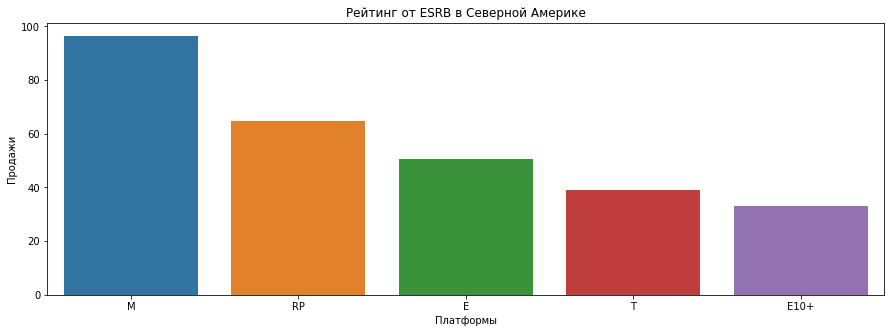

In [52]:
NA_pivot = (data_new.pivot_table(
    index='rating', values='na_sales', aggfunc='sum')).sort_values('na_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = NA_pivot, x = NA_pivot.index, y = 'na_sales').set(
    title='Рейтинг от ESRB в Северной Америке', xlabel = 'Платформы', ylabel = 'Продажи')
plt.show()

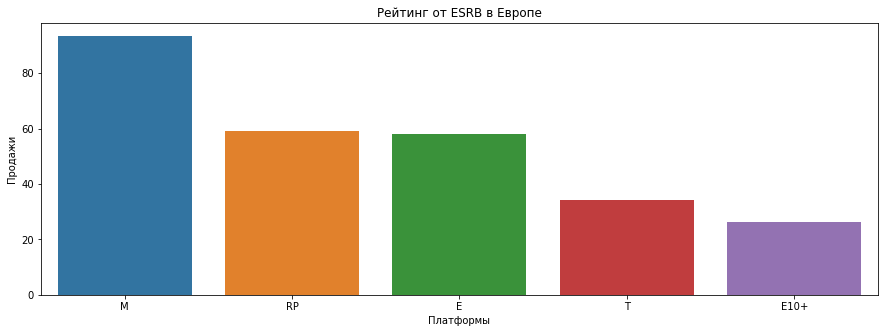

In [53]:
EU_pivot = (data_new.pivot_table(
    index='rating', values='eu_sales', aggfunc='sum')).sort_values('eu_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = EU_pivot, x = EU_pivot.index, y = 'eu_sales').set(
    title='Рейтинг от ESRB в Европе', xlabel = 'Платформы', ylabel = 'Продажи')
plt.show()

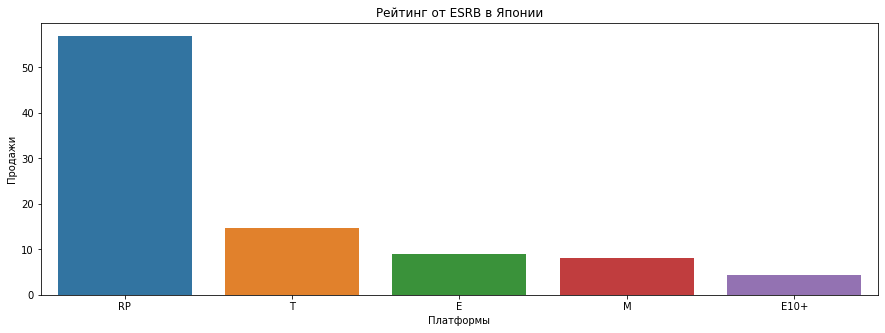

In [54]:
JP_pivot = (data_new.pivot_table(
    index='rating', values='jp_sales', aggfunc='sum')).sort_values('jp_sales', ascending = False)
plt.figure(figsize=(15,5))
sns.barplot(data = JP_pivot, x = JP_pivot.index, y = 'jp_sales').set(
    title='Рейтинг от ESRB в Японии', xlabel = 'Платформы', ylabel = 'Продажи')
plt.show()

**Вывод:** 

В Северной Америке и Европе распределение лидеров среди рейтингов одинаково: лидер М - Для взрослых (от 17 лет); далее RP - Рейтинг ожидается; далее Е - Для всех.

В Японии лидирующие рейтинги немного отличаются от Северной Америке и Европе: лидер RP - Рейтинг ожидается; далее Т - Подросткам; далее Е -  Для всех.

## Шаг 5. Проверка гипотезы

Необходимо проверить гипотезы:

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action и Sports разны.

Определим нулевую и альтернативную гипотезы для проверки первой поставленной гипотезы:

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги платформ Xbox One и PC разливаются.

Для проверки гипотез уберем из колонки user_score пропуски. Для удобства создадим новую таблицу data_actual. 

In [55]:
data_actual = data_new.loc[data_new['user_score'] > 0].reset_index(drop=True)

In [56]:
sample_1 = data_actual.query('platform == "XOne"')['user_score']
sample_2 = data_actual.query('platform == "PC"')['user_score']

alpha = .05 

results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


In [57]:
data_actual.pivot_table(index='platform', values='user_score', aggfunc='mean').sort_values(by='user_score', ascending = False)

,user_score
platform,
PSV,7.656164
3DS,7.138182
WiiU,7.087500
PS4,6.828099
XOne,6.594545
Wii,6.350000
PC,6.298361
PS3,6.014286
X360,5.771084


**Вывод:** Мы обозначили две гипотезы: нулевая гипотеза -- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; альтернативная гипотеза -- Средние пользовательские рейтинги платформ Xbox One и PC различаются. В ходе проверки мы не смогли отвергнуть нулевую гипотезу. Дополнительно провели проверку и наглядно увидели, что средние значения между XOne и PC практически не отличаются (XOne - 6.521429, PC - 6.518182).

Теперь проверим вторую гипотезу. 

Определим нулевую и альтернативную гипотезы для проверки второй поставленной гипотезы:

* Средние пользовательские рейтинги жанров Action и Sports равны;
* Средние пользовательские рейтинги жанров Action и Sports отличаются.

In [58]:
sample_1 = data_actual.query('genre == "Action"')['user_score']
sample_2 = data_actual.query('genre == "Sports"')['user_score']

alpha = .05 

results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


In [59]:
data_actual.pivot_table(index='genre', values='user_score', aggfunc='mean').sort_values(by='user_score', ascending = False)

,user_score
genre,
Puzzle,7.975000
Adventure,7.470213
Role-Playing,7.348571
Strategy,7.216667
Fighting,6.983784
Misc,6.968293
Action,6.760606
Platform,6.741379
Shooter,6.549074


**Вывод:** Мы обозначили две гипотезы: нулевая гипотеза -- Средние пользовательские рейтинги жанров Action и Sports равны; альтернативная гипотеза -- Средние пользовательские рейтинги жанров Action и Sports отличаются. В ходе проверки мы отвергли нулевую гипотезу. Показатели между жанрами отличаются достаточно (Action - 6.781900, Sports - 5.901587) чтобы мы приняли решение отвергнуть нулевую гипотезу.

## Общий вывод

В наше распоряжение попали данные интернет-магазине "Стримчик", который продаёт по всему миру компьютерные игры. Наша задача была -- выявить определяющие успешность игры закономерности. 

Мы провели тщательную предобработку данных, заполнили пропуски и избавились от ненужных строк, изменили типы данных и названия колонок, проверили данные на дубликаты. Мы выявили самые популярные жанры и платформы для разных регионов. К концу нашего исследования мы определили гипотезы и вынесли заключения. 

Итоги: 

* Топ-5 самых популярных платформ: для Северной Америки - PS4, XOne, X360, 3DS, PS3; для Европы - PS4, XOne, PS3, PC, 3DS; для Японии - 3DS, PS4, PSV, PS3, WiiU. 
* Топ-5 самых популярных жанров: В Северной Америке - Shooter, Action, Sports, Role-Playing, Misc; В Европе - Action, Shooter, Sports, Role-Playing, Racing; В Японии - Role-Playing, Action, Fighting, Misc, Shooter.
* Топ среди рейтингов от организации ESRB: В Северной Америке и Европе: лидер М - Для взрослых (от 17 лет); далее RP - Рейтинг ожидается; далее Е - Для всех. В Японии: лидер RP - Рейтинг ожидается; далее Т - Подросткам; далее Е -  Для всех.